<a href="https://colab.research.google.com/github/sjkim-audio/guitar-bass-separator/blob/main/notebooks/archive/Exp003_Non_negative_Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 공유 드라이브에 있는 오디오 파일 다운로드

import gdown
import librosa
from IPython.display import Audio

# 1. 구글 드라이브 공유 링크에서 'FILE_ID' 부분만 추출
# 예: https://drive.google.com/file/d/1A2B3C.../view -> '1A2B3C...'
file_id = '1bjwVU8lThj2E1TDs1rwhZwZTcUgTOASc'

# 2. 다운로드할 URL 구성
url = f'https://drive.google.com/uc?id={file_id}'

# 3. 파일 저장 경로 및 이름 설정
output_filename = 'downloaded_audio.wav'

# 4. 파일 다운로드
gdown.download(url, output_filename, quiet=False)

# 5. 다운로드한 파일 로드 (48kHz 설정)
# y: 오디오 데이터, sr: 샘플링 레이트 (해당 음원은 48kHz로 렌더링됨)
try:
    y, sr = librosa.load(output_filename, sr=None)
    print(f"샘플링 레이트 {sr}Hz")
    print(f"오디오 길이: {len(y) / sr:.2f}초")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")

Audio(data=y, rate=sr)

In [ ]:
# 다운받은 오디오 데이터 멜스펙트로그램 시각화
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# 1. 멜 스펙트로그램 계산
# n_mels: 멜 필터의 개수 (보통 128개 사용)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# 2. 데시벨(dB) 스케일로 변환
# 스펙트로그램의 진폭을 로그 스케일(dB)로 변환하여 시각화 효과를 높입니다.
S_dB = librosa.power_to_db(S, ref=np.max)

# 3. 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
import librosa.decompose
from IPython.display import Audio, display

# 1. 오디오 로드
y, sr = librosa.load(output_filename, sr=48000)

# 2. STFT (단기 푸리에 변환) 수행
# 오디오를 스펙트로그램(복소수)으로 변환합니다.
S_full, phase = librosa.magphase(librosa.stft(y))

# 3. NMF 분해 (핵심 단계)
# components(W): 주파수 패턴, activations(H): 시간적 활성화 정도
# n_components=2 : 우리는 '베이스'와 '기타' 두 가지 소스 구별을 위해 2로 설정
W, H = librosa.decompose.decompose(S_full, n_components=2)

# 4. 분리된 결과 재구성 (마스킹 기법)
# 분해된 두 성분이 전체 소리에서 각각 얼마나 비중을 차지하는지 계산
# 결과적으로 원본 위상(phase) 정보를 입혀서 다시 오디오로 변환
result = []
S_approx_total = W @ H
for i in range(2):
    # 해당 컴포넌트의 스펙트로그램 재구성
    # W의 i번째 열(주파수)과 H의 i번째 행(시간)을 곱해(외적) 해당 소리의 전체 스펙트로그램 구성
    S_approx = np.outer(W[:, i], H[i, :])

    # [Hard Masking]
    # 내 성분(S_approx)이 다른 성분보다 크거나 같으면 1, 아니면 0
    # 즉, 더 지배적인 소리만 남기고 나머지는 버립니다.
    mask = np.where(S_approx >= (S_approx_total - S_approx), 1, 0)

    # 원본의 크기(Magnitude)에 마스크를 곱하고, 원본 위상(Phase)을 합침
    S_separated = S_full * mask

    # 다시 오디오 파형으로 변환 (iSTFT)
    y_separated = librosa.istft(S_separated * phase)
    result.append(y_separated)

# 5. 베이스와 기타 자동 분류
# 두 결과물 중 '무게중심(Spectral Centroid)'이 더 낮은 쪽을 베이스로 간주.
centroid0 = np.mean(librosa.feature.spectral_centroid(y=result[0], sr=sr))
centroid1 = np.mean(librosa.feature.spectral_centroid(y=result[1], sr=sr))

if centroid0 < centroid1:
    bass_part, guitar_part = result[0], result[1]
else:
    bass_part, guitar_part = result[1], result[0]

# 6. 결과 확인
print("🎶 NMF Separation Result")
print("-" * 30)

print("🎸 Estimated Bass (NMF):")
display(Audio(bass_part, rate=sr))

print("🎸 Estimated Guitar (NMF):")
display(Audio(guitar_part, rate=sr))

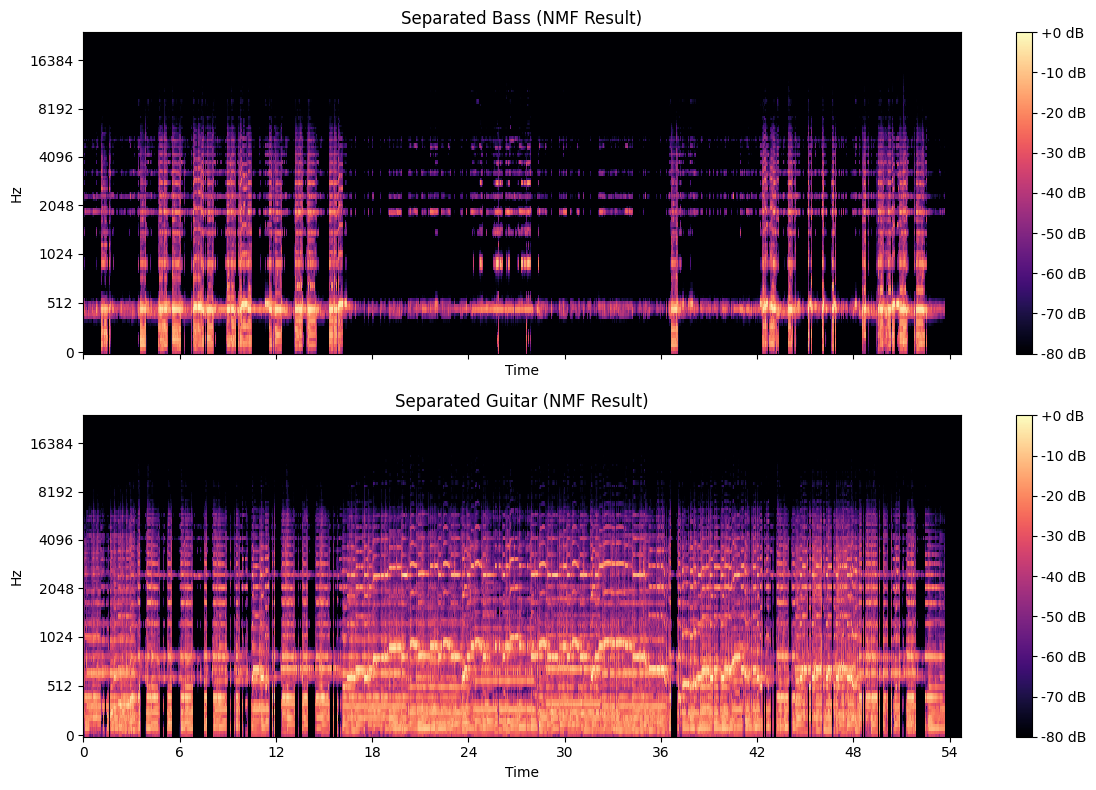

In [ ]:
# 분리된 트랙 시각화
# 시각화를 위한 함수 정의
def plot_mel_spectrogram(y, sr, title, ax):
    # 1. 멜 스펙트로그램 계산
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    # 2. dB로 변환
    S_dB = librosa.power_to_db(S, ref=np.max)

    # 3. 그리기
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(title)
    return img

# 그래프 그리기 설정 (2행 1열)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 1. 베이스 트랙 시각화
img1 = plot_mel_spectrogram(bass_part, sr, 'Separated Bass (NMF Result)', axes[0])
fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

# 2. 기타 트랙 시각화
img2 = plot_mel_spectrogram(guitar_part, sr, 'Separated Guitar (NMF Result)', axes[1])
fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

**NMF (Non-negative Matrix Factorization)**

비음수 행렬 분해를 이용해 기타와 베이스를 분리하는 실습

---

**1. 사용기술**

NMF란 무엇인가?

기존 주파수 필터: 기준 주파수 아래는 베이스, 위는 기타라고 정의

NMF: 반복되는 패턴 추정. 단순히 높낮이가 아니라 **소리의 성질(Timbre)** 을 기반으로 분리

---

**2. 실습 과정**

1) 계산 오류 수정
- components(주파수 패턴)와 activations(시간 패턴)를 중 한 요소만 받아 계산하려다 행렬 크기(Shape)가 맞지 않아 오류 발생
- W(주파수 특징)와 H(시간 특징) 두 개의 행렬로 쪼개는 기술로 소리를 다시 합치려면 모두 필요

2) n_fft 조정
- 기존 기본값(2048)을 1024, 4096, 8192 등의 다른 값으로 변경해가며 주파수 해상도 변화 관찰
- 유의미한 성능 향상 없음
- (특이사항) istft 파트에 n_fft=n_fft_size 코드를 추가할 경우 값에 따라 재생 속도와 길이가 변경됨. 숫자가 클수록 파형이 늘어난 것처럼 속도가 느려짐

3) 마스킹 방식 변경
- Soft Masking 에서 Hard Masking 으로
- 유의미한 성능 향상 없음
- 분리된 트랙에서 볼륨의 울렁거림이 심해지고, 고주파 음이 베이스 트랙에 잡힘

---

**3. 실습 결과**

1) 기존 Frequency Filtering 을 사용하였을 때보다도 분리도가 훨씬 떨어짐.. 기타와 베이스를 거의 구분하지 못함

2) 분리된 트랙을 멜 스펙트로그램으로 시각화해 비교
- 기타, 베이스 두 트랙 모두 상당한 블리딩 발생, 기타 트랙에서도 저음역대가 상당히 살아있고, 베이스 트랙에서도 고음역대 잔음이 있음
- 전체 트랙에서 분리가 과하게 이루어진 부분과 아닌 부분이 나뉘어짐을 확인할 수 있었음
- -> 리드 기타의 솔로가 한옥타브 올라가는 시점(18초 부근)부터 두 트랙의 분리 정도가 심해지는 것을 확인.
- 기타가 베이스에 비해 유의미하게 높은 음을 치는 구간에서 분리를 강하게 함

